# Programming in the Scientific Environment 

## Aplications to Astrophysics II. Data fitting

There are many ways to fit data to a model. In this notebook we fit some simulated data using different common methodologies in astrophysics.

   1. First, we generate mock data from a linear model with white noise.
   2. Fit the data using the astropy utilities.
   3. Fit the data using a Python implementation of a MCMC sampler.

### Data Simulation

Model: $f(x) = ax +b$

White noise: $\mathcal{N}(0,\sigma)$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1000)

def model(theta,x):
    a, b = theta
    return a * x +  b
# Model parameters.
a  = 0.75
b = -3
truths = [a,b]


# Generate data from the model.
N = 50
xmin = -10
xmax = 10
x = np.random.uniform(low=xmin, high=xmax, size=N)


y = model(truths,x)
sigma = np.random.uniform(low=2,high=5,size=x.size)
yerr = sigma*np.random.randn(x.size)
y += yerr 

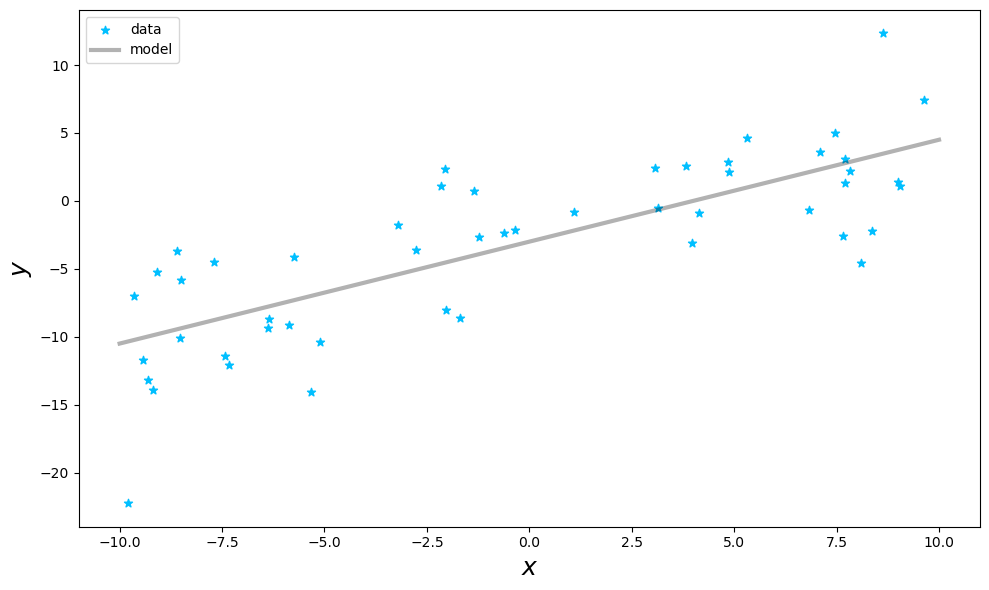

In [2]:
x0 = np.linspace(xmin, xmax, 500)


fig,ax = plt.subplots(figsize=(10,6))

ax.scatter(x, y, marker='*', color='deepskyblue',label='data')
ax.plot(x0,model(truths,x0), color='k',alpha=.3, linewidth=3,label='model')

ax.set_xlabel(r"$x$",fontsize=18)
ax.set_ylabel(r"$y$",fontsize=18)
ax.legend()
plt.tight_layout()

### astropy 

Astropy has a series of functions to easily fit data to a given model.

Normally the fit is obtained using either the least squares method, i.e., minimizing the following function:

\begin{equation}
E = \sum\limits_{i=1}^{N}\dfrac{(y_i-f(x_i))^2}{N} \, ,
\end{equation}

or the weighted least squares method aka minimizing the $\chi^2$:

\begin{equation}
\chi^2 = \sum\limits_{i=1}^{N}\dfrac{(y_i-f(x_i))^2}{\sigma_i^2} \, ,
\end{equation}

Fits with astropy:

   1. A model is defined either from the astropy list of defined models (check [astropy functions](https://docs.astropy.org/en/stable/modeling/#functions)), or customizing a function e.g.,
   ```python
import numpy as np
from astropy.modeling.models import custom_model
@custom_model
def custom_function(x, a=1, b=2, c=3):
        return a * np.sin(b*x + c)
```
   2. We choose the method (fitter) with which the fit is maded (e.g., $\chi^2$)
   
   3. The model and the data is given to the fitter to obtain the best fit models parameters


In [3]:
from astropy.modeling import models,fitting

In [4]:
astropy_model = models.Linear1D()
fitter = fitting.LinearLSQFitter()
best_fit = fitter(astropy_model, x, y)
print(best_fit)

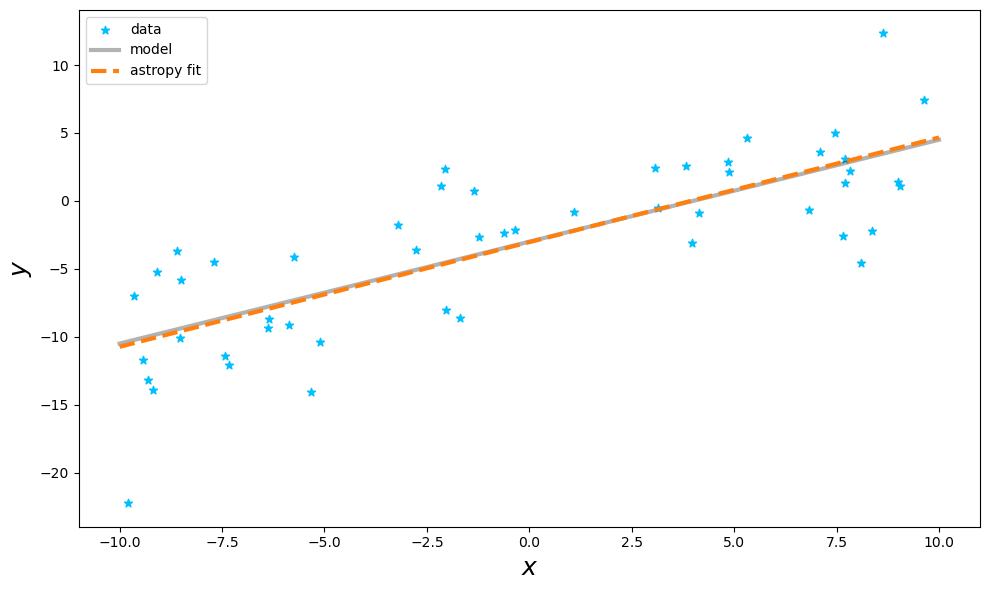

In [6]:
fig,ax = plt.subplots(figsize=(10,6))

ax.scatter(x, y, marker='*', color='deepskyblue',label='data')
ax.plot(x0,model(truths,x0), color='k',alpha=.3, linewidth=3,label='model')
ax.plot(x0,best_fit(x0), color='C1', linestyle='--', linewidth=3,label='astropy fit')

ax.set_xlabel(r"$x$",fontsize=18)
ax.set_ylabel(r"$y$",fontsize=18)
ax.legend()
plt.tight_layout()

In [7]:
weighted_best_fit = fitter(astropy_model, x, y, weights=1/sigma**2)
print(weighted_best_fit)

Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          slope            intercept     
    ------------------ ------------------
    0.7116033917190546 -3.145076065743068


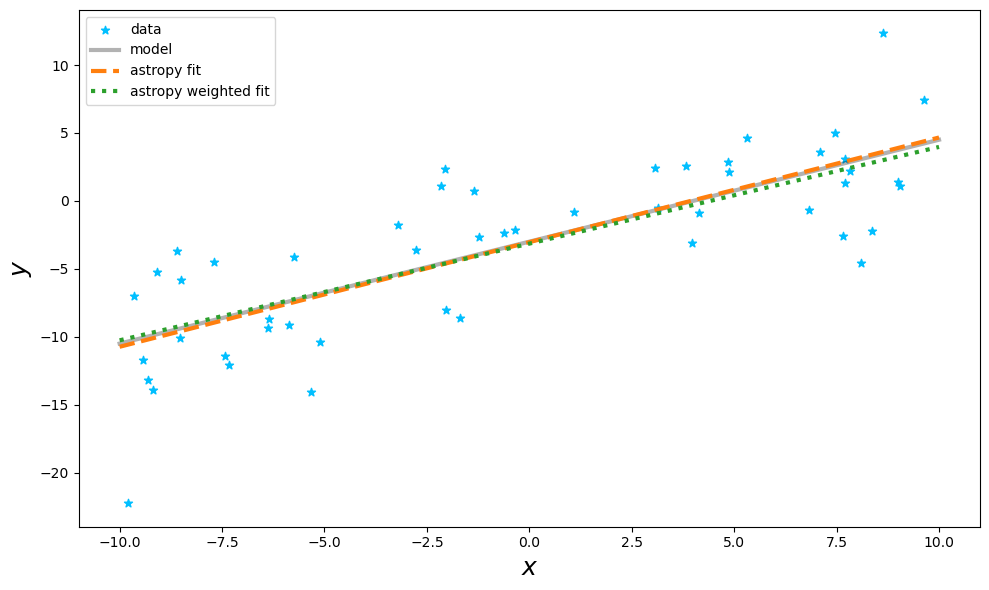

In [8]:
fig,ax = plt.subplots(figsize=(10,6))

ax.scatter(x, y, marker='*', color='deepskyblue',label='data')
ax.plot(x0,model(truths,x0), color='k',alpha=.3, linewidth=3,label='model')
ax.plot(x0,best_fit(x0), color='C1', linestyle='--', linewidth=3,label='astropy fit')
ax.plot(x0,weighted_best_fit(x0), color='C2', linestyle=':', linewidth=3,label='astropy weighted fit')


ax.set_xlabel(r"$x$",fontsize=18)
ax.set_ylabel(r"$y$",fontsize=18)
ax.legend()
plt.tight_layout()

### MCMC  fitting

MCMC methods are algorithms able to sample from a probability distribution, and hence provide an estimation of it. For example, we could draw random samples from a distribution similar to the $\chi^2$ distribution:


$$\mathcal{L} = \dfrac{1}{\sqrt{(2\pi)^{N} \det(\mathbf{C})}} \exp\left(-\dfrac{1}{2}(y-m(\theta))^{T}\mathbf{C}^{-1}(y-m(\theta))\right)$$

$$\log \mathcal{L} = -\dfrac{1}{2}\chi^2 + C $$

and obtain the best fit model parameters from the sampled marginalized parameters distributions. This method allows to draw samples from Bayesian probability distributions:

\begin{equation}
    \mathcal{P}(\theta|d) \propto \mathcal{P}(d|\theta) \mathcal{P}(\theta) \, ,
\end{equation}

where $\mathcal{P}(\theta|d)$ is the posterior distribution, $\mathcal{P}(d|\theta)$ is the likelihood, and $\mathcal{P}(\theta)$ is the prior information.

In this examples we will draw samples from a likelihood function for a better comparison with the other fit.

There are several python libraries with implemented MCMC samplers. In this notebook we use **emcee** which is an MIT licensed pure-Python implementation of Goodman & Weare’s Affine Invariant Markov chain Monte Carlo (MCMC) Ensemble sampler.

Installation with conda:

    conda update conda
    conda install -c conda-forge emcee
    
Installation with pip:
    
    python -m pip install -U pip
    pip install -U setuptools setuptools_scm pep517
    pip install -U emcee


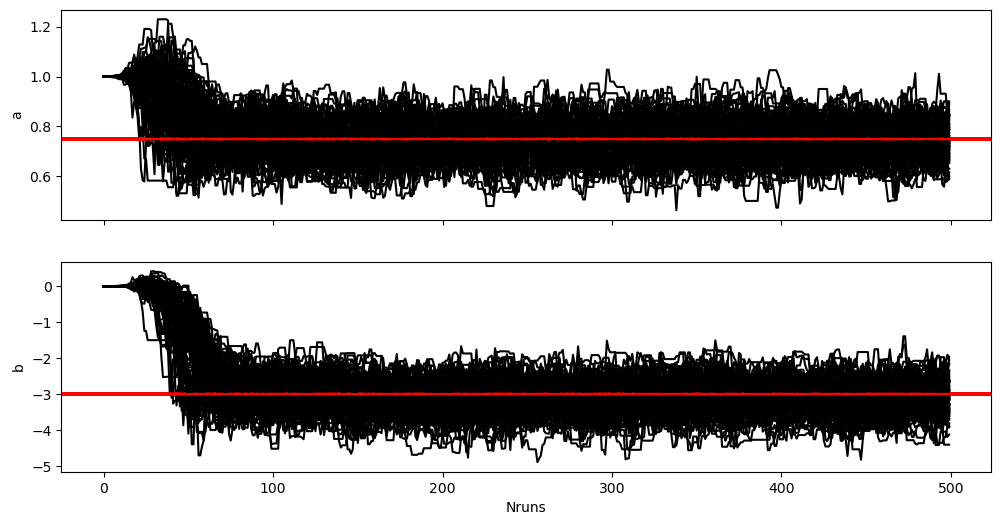

In [36]:
import emcee

def model(theta,x):
    a, b = theta
    return a * x +  b

def log_likelihood(theta, x, y, sigma):
    m = model(theta,x)
    return -0.5 * np.sum((y - m) ** 2 / sigma**2) -  0.5 * x.size * np.log(2 * np.pi) - np.sum(np.log(sigma))

initial_parameters = [1,0] 
ndim, nwalkers = len(initial_parameters), 100

pos = [initial_parameters + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=(x, y, sigma))

Nruns = 500
sampler.run_mcmc(pos, Nruns);

labels = ['a','b']
fig, axes = plt.subplots(nrows=ndim,ncols=1,sharex=True,figsize=(12,6))

for j in np.arange(ndim):
    axes[j].set_ylabel(labels[j])
    for i in np.arange(nwalkers):            
        axes[j].plot(np.arange(Nruns), sampler.chain[i,:,j],'k')
        axes[j].axhline(y=truths[j], xmin=0, xmax=Nruns, color='r')

axes[-1].set_xlabel('Nruns')

ndiscard = 100
samples = sampler.chain[:,ndiscard:,:].reshape((-1, ndim))
output_emcee = np.mean(samples,axis=0)